# Star galaxy separation 

Here I seperate images of stars and galaxies from each other. This is my first attempt on image data. I choose this problem because it is relatively simple, at least with sufficient signal to noise star. Galaxies should be relatively easy to separate because stars are a homogenous class and while galaxies are less simple, they should be usually larger than stars. 

This notebook is the last of several and applies many steps learned before. 
First I load the needed libraries. 

In [22]:
#standard libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.cm as cm
import sys
import os
#to access astronomical images in fits format
from astropy.io import fits
#torch functions
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
#sklearn helper functions
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score,f1_score, log_loss, ConfusionMatrixDisplay
#xgboost for comparison
from xgboost import XGBClassifier
#logistic regression for comparison 
from sklearn.linear_model import LogisticRegression
#own functions
from functions_ml import *
from functions_wcs import *
#for accesing saved models  
#import pickle
#supresses warnings, which dont matter
#import warnings
#warnings.filterwarnings('ignore')

## Data introduction

Now I am loading the table and associated images on the classification and other properties of the objects to be classified. 

This is done in get_small_objects.py  Afer exploration of other options in the other notebooks I use several criteria to ensure clean samples of stars and galaxies. I ignore QSO (quasi stellar objects) because while they usually very similar to stars it is not 100% the case. In addition I combine spectral class (star versus galaxy) classfications with shape based criteria. For the latter I require that the shape is star like in the images in all three filters with highest signal to noise ration. These are images in g, r and i. 
I choose as size of the cutout image a box radius of 11. That is relatively small because stars should be clear with a small window size and a larger one would be only a waste. It is not clear that this is the optimal size. 

These images are now loaded and the classes statistic is shown. 

In [23]:
#to expand to using several files later 
df2=pd.read_csv('stripe82_1_small_table.csv')
cut_outs2=np.load('stripe82_1_small_im.npy')
print(df2['class'].value_counts())

GALAXY    3092
STAR      1599
Name: class, dtype: int64


There are about twice as much galaxies as star. This imbalance is probably small enough that it can be ignored.

Now I display two galaxies. 

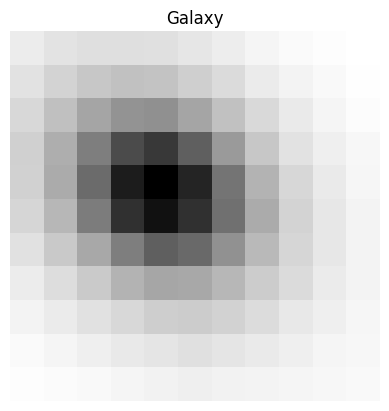

In [24]:
plt.axis('off')
plt.title("Galaxy")
plt.imshow(1-cut_outs2[:,:,0,0].T,cmap=cm.gray, interpolation='nearest')

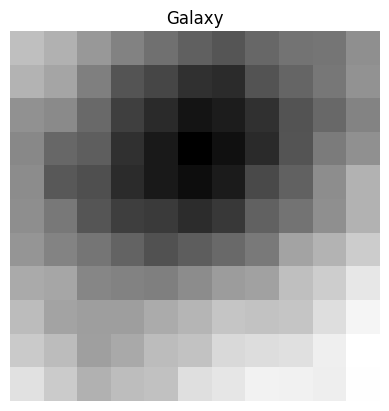

In [25]:
fg=df2['class'][df2['class']=='GALAXY']
plt.axis('off')
plt.title("Galaxy")
plt.imshow(1-cut_outs2[:,:,0,fg.index[1]].T,cmap=cm.gray, interpolation='nearest')

It is visible that there is variation in galaxy shape. Now two stars. 

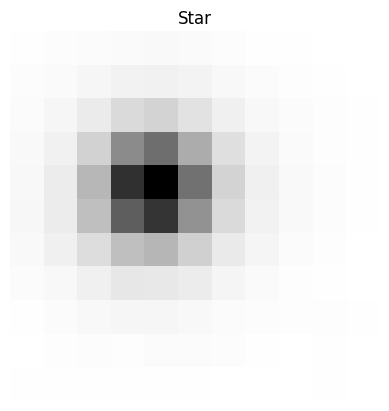

In [26]:
#finding star for display
fs=df2['class'][df2['class']=='STAR']
plt.axis('off')
plt.title("Star")
plt.imshow(1-cut_outs2[:,:,0,fs.index[0]].T,cmap=cm.gray, interpolation='nearest')

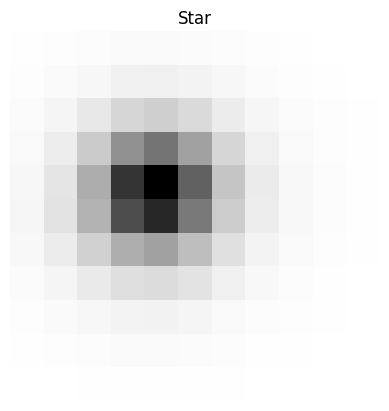

In [27]:
plt.axis('off')
plt.title("Star")
plt.imshow(1-cut_outs2[:,:,0,fs.index[1]].T,cmap=cm.gray, interpolation='nearest')

In contrast, different stars look very similar when scaled to their maxima. As it should be the galaxies are less concentrated than the stars. 

Because of the relevant noise in astronomical images I do not rescale the cut-out images, since rescaling can cause that noise level is very different between different images, while it should be rather similar in this data set.   

## Fit preparation

I use four different algorithms here. Two which do not use neural network, that are logisted regression and the tree based algorithm xgboost. In addition I use two neural networks: Firstly a fully connected multilayer network with several layers as perceptron. Secondly, a network which uses among others twodimensional convolutional layers, this network should be optimized for images. 

I now start with the setup tasks for the algorithm. Many are needed for the use of pytorch.
First I add the cpu. 

In [28]:
#adding cpu
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")



Using cpu device


Next I add the image columns to the data frame as flattened columns. That is needed because all algorithms besides convolutional cannot work on images as input.  

In [29]:
x=0
for i in range(cut_outs2.shape[0]):
    for j in range(cut_outs2.shape[1]):
        df2[x]=cut_outs2[i,j,0,:]
        x+=1
print(df2.columns)   

Index(['Unnamed: 0',      'index',      'objid',         'ra',        'dec',
         'psfMag_u',   'psfMag_g',   'psfMag_r',   'psfMag_i',   'psfMag_z',
       ...
                111,          112,          113,          114,          115,
                116,          117,          118,          119,          120],
      dtype='object', length=292)


/tmp/ipykernel_12550/1636207740.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[x]=cut_outs2[i,j,0,:]
/tmp/ipykernel_12550/1636207740.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[x]=cut_outs2[i,j,0,:]
/tmp/ipykernel_12550/1636207740.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

Next I split into test and train. 

In [30]:
#image_* are the feature for convoltional
# for other feature* are used 
feature_train,feature_test,target_train, target_test,image_train,image_test,df_train,df_test= train_test_split(df2.loc[:,0:120],df2.loc[:,"galaxy"],cut_outs2.T,df2,train_size=0.70, shuffle=True, random_state=1)
print("shape of image train data")
print(image_train.shape)

shape of image train data
(3283, 1, 11, 11)


Now I change the target data type to numpy array where that is not yet the case. 

In [31]:
 
feature_train, target_train = np.array(feature_train), np.array(target_train)
feature_test, target_test = np.array(feature_test), np.array(target_test)
print(type(target_train),type(image_test))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


Now I create the data sets as needed for both neural network types. 

In [32]:
train_dataset = ClassificationDataset(torch.from_numpy(feature_train).float(), torch.from_numpy(target_train).float())
test_dataset = ClassificationDataset(torch.from_numpy(feature_test).float(), torch.from_numpy(target_test).float())
train_im_dataset = ClassificationDataset(torch.from_numpy(image_train).float(), torch.from_numpy(target_train).float())
test_im_dataset = ClassificationDataset(torch.from_numpy(image_test).float(), torch.from_numpy(target_test).float())


Now I define the parameters needed for a first exploratory fit. 

In [33]:
NUM_FEATURES=121
BATCH_SIZE = 32
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_pred = DataLoader(dataset=train_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

Finally I define the the perceptron model plus the final parameters. 

In [34]:
model =BinaryClassification3(NUM_FEATURES)
model.to(device)
print(model)

BinaryClassification3(
  (fc1): Linear(in_features=121, out_features=60, bias=True)
  (fc2): Linear(in_features=60, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=8, bias=True)
  (fc4): Linear(in_features=8, out_features=1, bias=True)
)


This network has 3 layers before the output layer. 

## First fits

Now I run the fit. 

In [35]:
#data collected here
loss_stats_per = {
    'train': [], 'test': []
}
EPOCHS=60
LEARNING_RATE=0.001
torch_fit(model,train_loader,test_loader,EPOCHS,BATCH_SIZE,LEARNING_RATE,loss_stats_per)

Begin training.


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.45896 | Test Loss: 0.57071
Epoch 002: | Train Loss: 0.36850 | Test Loss: 0.41639
Epoch 003: | Train Loss: 0.30856 | Test Loss: 0.34888
Epoch 004: | Train Loss: 0.27266 | Test Loss: 0.27716
Epoch 005: | Train Loss: 0.21158 | Test Loss: 0.26181
Epoch 006: | Train Loss: 0.17530 | Test Loss: 0.18587
Epoch 007: | Train Loss: 0.11180 | Test Loss: 0.16951
Epoch 008: | Train Loss: 0.05963 | Test Loss: 0.52603
Epoch 009: | Train Loss: 0.05110 | Test Loss: 0.17905
Epoch 010: | Train Loss: 0.07359 | Test Loss: 0.17809
Epoch 011: | Train Loss: 0.04038 | Test Loss: 0.16532
Epoch 012: | Train Loss: 0.04035 | Test Loss: 0.09709
Epoch 013: | Train Loss: 0.03966 | Test Loss: 0.16471
Epoch 014: | Train Loss: 0.04121 | Test Loss: 0.16522
Epoch 015: | Train Loss: 0.07375 | Test Loss: 0.12259
Epoch 016: | Train Loss: 0.15174 | Test Loss: 0.10161
Epoch 017: | Train Loss: 0.07375 | Test Loss: 0.09779
Epoch 018: | Train Loss: 0.13562 | Test Loss: 1.06813
Epoch 019: | Train Loss: 0.1

I now plot the loss against the epoch. 

Text(0, 0.5, 'BCE loss')

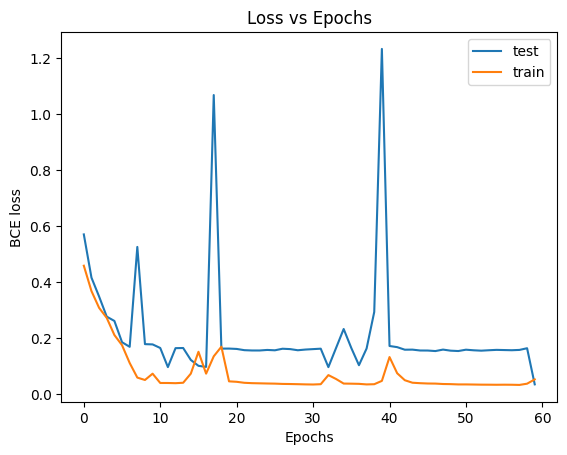

In [36]:

plt.plot(loss_stats_per['test'],label='test')
plt.plot(loss_stats_per['train'],label='train')
plt.legend(loc="best")
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('BCE loss')

The loss clearly improves overall for test and train with some variation showing that it is not robust. The number of iteration here is likely not enough as expected in a first exploration. Since the loss is smaller in test there is likely overfitting. 

Now to the convolutional algorithm. The data needs to be loaded separately because now the images are used. 

In [38]:
train_im_loader = DataLoader(dataset=train_im_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_im_loader = DataLoader(dataset=test_im_dataset, batch_size=1)
train_im_loader_pred = DataLoader(dataset=train_im_dataset, batch_size=1)

I now load the convolutional neural network. 

In [39]:
keep_prob=1
model2 =CNNBinary3(keep_prob)
model2.to(device)
print(model2)

CNNBinary3(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (fc1): Linear(in_features=32, out_features=64, bias=True)
  (layer3): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
  )
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)


/home/tobias/ml-testing/astr-images/functions_ml.py:133: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


This network two structures consisting of convolutional layers and pooling which consider the image structures, then one multiconnected and finally a later to get the single probablity as output. 

Now define the dictionary for data collection and then fit the data. 

In [40]:
loss_stats_conv = {
    'train': [], 'test': []
}
EPOCHS=60
BATCH_SIZE=32
LEARNING_RATE=0.001
torch_fit(model2,train_im_loader,test_im_loader,EPOCHS,BATCH_SIZE,LEARNING_RATE,loss_stats_conv)

Begin training.


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 3.28872 | Test Loss: 0.06755
Epoch 002: | Train Loss: 0.95536 | Test Loss: 0.49017
Epoch 003: | Train Loss: 0.21989 | Test Loss: 0.27408
Epoch 004: | Train Loss: 0.40336 | Test Loss: 0.18404
Epoch 005: | Train Loss: 0.32683 | Test Loss: 0.16704
Epoch 006: | Train Loss: 0.10219 | Test Loss: 0.16502
Epoch 007: | Train Loss: 0.10105 | Test Loss: 0.04722
Epoch 008: | Train Loss: 0.09900 | Test Loss: 0.04715
Epoch 009: | Train Loss: 0.09953 | Test Loss: 0.04593
Epoch 010: | Train Loss: 0.09882 | Test Loss: 0.04581
Epoch 011: | Train Loss: 0.09750 | Test Loss: 0.04497
Epoch 012: | Train Loss: 0.44108 | Test Loss: 0.10893
Epoch 013: | Train Loss: 0.01771 | Test Loss: 0.11238
Epoch 014: | Train Loss: 0.01831 | Test Loss: 0.10406
Epoch 015: | Train Loss: 0.01706 | Test Loss: 0.10368
Epoch 016: | Train Loss: 0.01597 | Test Loss: 0.03804
Epoch 017: | Train Loss: 0.01545 | Test Loss: 0.03351
Epoch 018: | Train Loss: 0.01240 | Test Loss: 0.03153
Epoch 019: | Train Loss: 0.0

Below I plot both neural network results. 

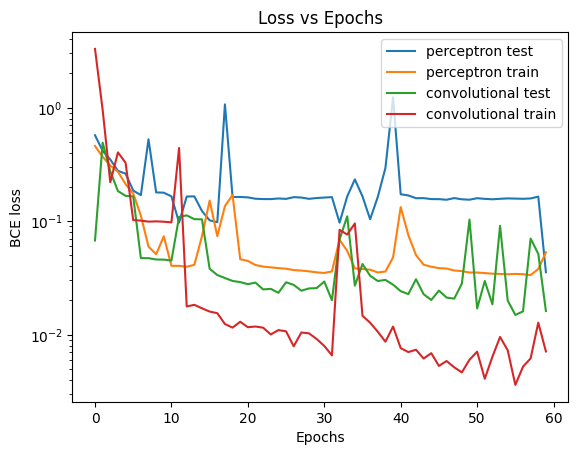

In [41]:
plt.plot(loss_stats_per['test'],label='perceptron test')
plt.plot(loss_stats_per['train'],label='perceptron train')
plt.plot(loss_stats_conv['test'],label='convolutional test')
plt.plot(loss_stats_conv['train'],label='convolutional train')
plt.legend(loc="best")
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('BCE loss')
plt.yscale("log")
#plt.ylim(0,2)


Convolutional looks better, but there is overfitting, the final loss is not the best. 

Now I do some other algorithms with standard settings. First xgboost. 

In [42]:
xc1=XGBClassifier(max_depth=6).fit(feature_train,target_train)

Now logistic regression. 

In [43]:
#2000 in train 91 56,  test 65 45  not converged warning
#now converged same numbers
lc1=LogisticRegression(max_iter=3000,penalty='none').fit(feature_train,target_train)

Now I predict results and get confusing matrixes. 

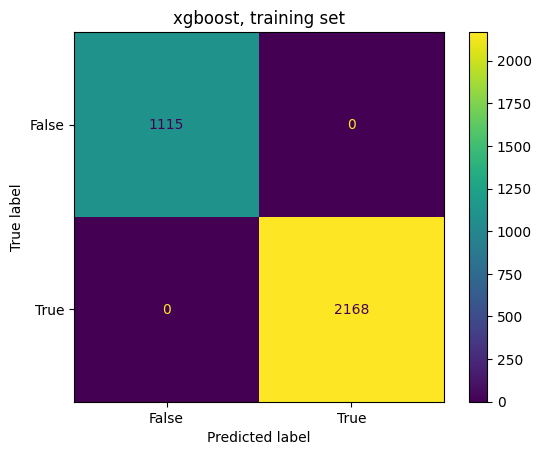

In [44]:
x_pred_train=xc1.predict(feature_train)
x_pred_test=xc1.predict(feature_test)
x_pred_prob_train=xc1.predict_proba(feature_train)
x_pred_prob_test=xc1.predict_proba(feature_test)
x_conf_train = confusion_matrix(target_train, np.round(x_pred_train), labels=xc1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=x_conf_train,
                               display_labels=xc1.classes_)
disp.plot()
plt.title(f"xgboost, training set")
plt.show()

In the training set the classfication is perfect, indicating likely overfitting.


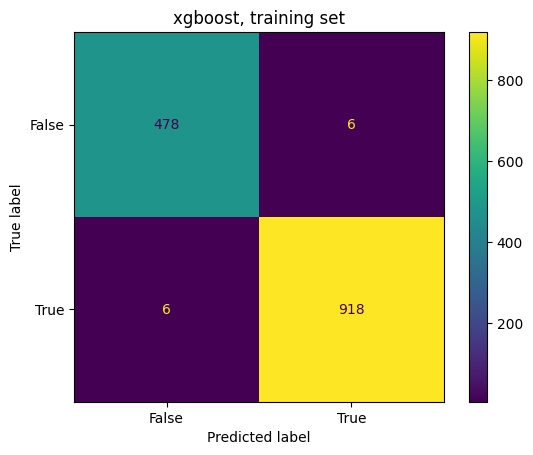

In [45]:
x_conf_test = confusion_matrix(target_test, np.round(x_pred_test), labels=xc1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=x_conf_test,
                               display_labels=xc1.classes_)
disp.plot()
plt.title(f"xgboost, training set")
plt.show()

Here 6 are missiclasfied confirming that there is over fitting.

Now logistic regression. 

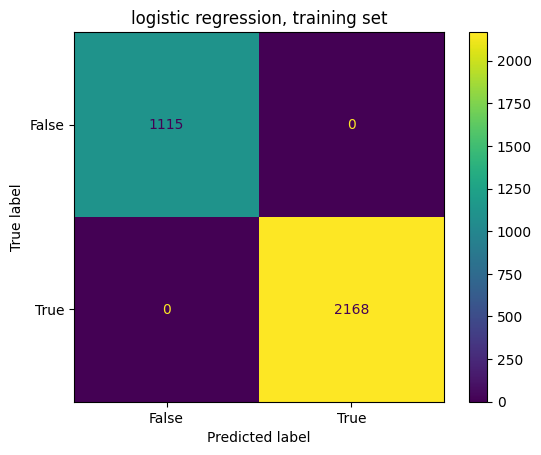

In [46]:
l_train_pred=lc1.predict(feature_train)
l_test_pred=lc1.predict(feature_test)
l_train_pred_prob=lc1.predict_proba(feature_train)
l_test_pred_prob=lc1.predict_proba(feature_test)
l_conf_train = confusion_matrix(target_train, np.round(l_train_pred), labels=lc1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=l_conf_train,
                               display_labels=lc1.classes_)
disp.plot()
plt.title(f"logistic regression, training set")
plt.show()

Again perfect classification in train. 

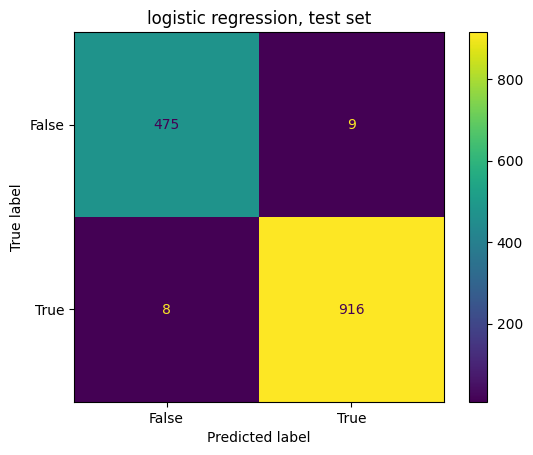

In [47]:
l_conf_test = confusion_matrix(target_test, np.round(l_test_pred), labels=lc1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=l_conf_test,
                               display_labels=lc1.classes_)
disp.plot()
plt.title(f"logistic regression, test set")
plt.show()

Here are some more missclasfied than with xgboost but still rather few. 

Now prediction for neural network. 

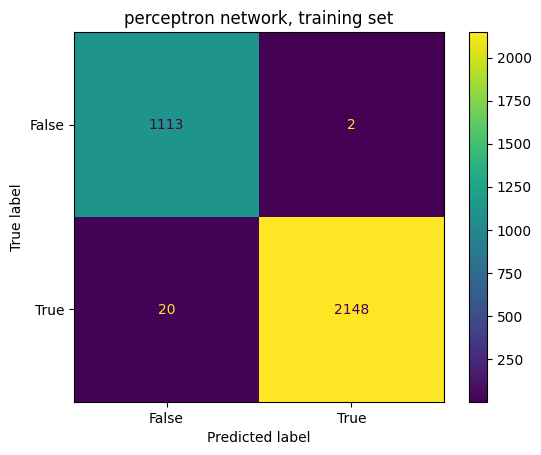

In [48]:
p_pred_test=pred_torch(model,test_loader)
p_pred_train=pred_torch(model,train_loader_pred)
p_conf_train = confusion_matrix(target_train, np.round(p_pred_train), labels=lc1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=p_conf_train,
                               display_labels=lc1.classes_)
disp.plot()
plt.title(f"perceptron network, training set")
plt.show()

Here the classification is not perfect in training. Possible the fit is not yet converged. 

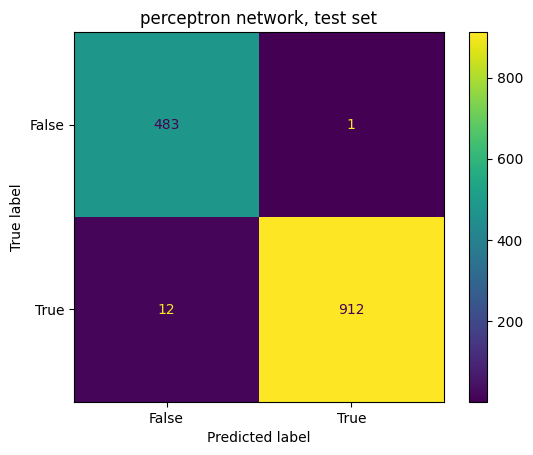

In [51]:
p_conf_test = confusion_matrix(target_test, np.round(p_pred_test), labels=lc1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=p_conf_test,
                               display_labels=lc1.classes_)
disp.plot()
plt.title(f"perceptron network, test set")
plt.show()

In tets it is better than logistic regression and xgboost.

Now convolutional network. 

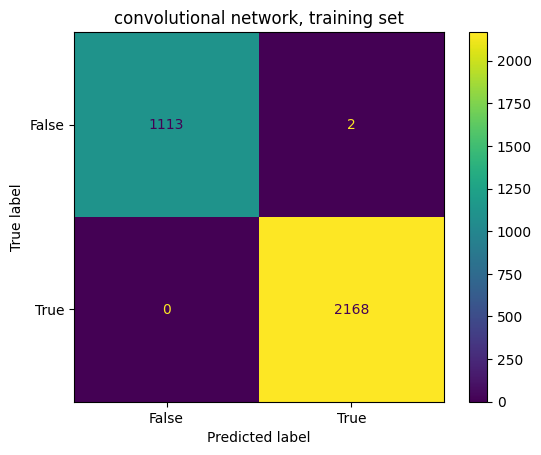

In [53]:
c_pred_test=pred_torch(model2,test_im_loader)
c_pred_train=pred_torch(model2,train_im_loader_pred)
c_conf_train = confusion_matrix(target_train, np.round(c_pred_train), labels=lc1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=c_conf_train,
                               display_labels=lc1.classes_)
disp.plot()
plt.title(f"convolutional network, training set")
plt.show()

This is nearly perfect in train, which is likely overfitting. Again checking with test. 

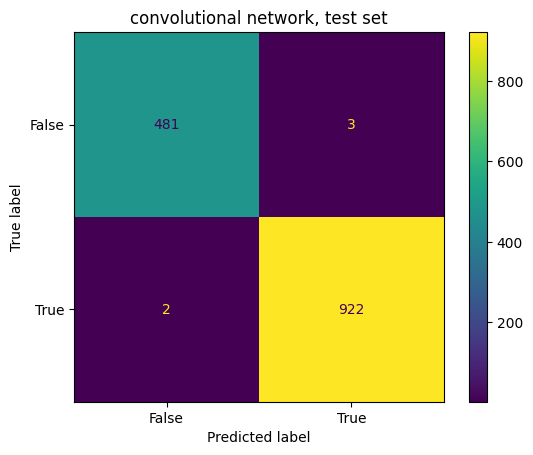

In [54]:
c_conf_test = confusion_matrix(target_test, np.round(c_pred_test), labels=lc1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=c_conf_test,
                               display_labels=lc1.classes_)
disp.plot()
plt.title(f"convolutional network, test set")
plt.show()

This is slightly better than the perecptron, thus it is the best method, but thne differences are small for the data size. 

Now I am calculating f1-scores for all. 

In [60]:
print("F1-scores")
print(f"Logistic train {np.round(f1_score(target_train,l_train_pred),5)}")
print(f"Logistic test {np.round(f1_score(target_test,l_test_pred),5)}")
print(f"xgboost train {np.round(f1_score(target_train,x_pred_train),5)}")
print(f"xgboost test {np.round(f1_score(target_test,x_pred_test),5)}")
print(f"perceptron train {np.round(f1_score(target_train,np.round(p_pred_train)),5)}")
print(f"perceptron test {np.round(f1_score(target_test,np.round(p_pred_test)),5)}")
print(f"conv2d train {np.round(f1_score(target_train,np.round(c_pred_train)),5)}")
print(f"conv2d test {np.round(f1_score(target_test,np.round(c_pred_test)),5)}")

F1-scores
Logistic train 1.0
Logistic test 0.99081
xgboost train 1.0
xgboost test 0.99351
perceptron train 0.99491
perceptron test 0.99292
conv2d train 0.99954
conv2d test 0.9973


All rather good, the differences are small. In test convolutional network is best, then xgboost, then preceptron, then logistic regression.
Always test is worse than train, such there is overfitting. 

As strategy against it I use l2 regularization because that is possible for all algorithms. 

I  now run  convolutional network for several regularization. I choose 200 epochs that convergence is possible when no overfitting occurs. With overfitting is will still change but since the aim here is to find the regularization which has not that problem, it is not a problem. 

In [17]:
regs=[0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3,1]
#here a small regulrization is done for speed
conv2d_stats=run_loop_torch(CNNBinary3,train_im_loader,test_im_loader,train_im_loader_pred,target_train,target_test,10,64,0.001,regs)
np.savetxt("conv2d_b_reg1_10.txt",conv2d_stats)
#loading past run with more iterations
con2d_stats=np.loadtxt("conv2d_b_reg1_200.txt")

running reg of 0.0001
Begin training.


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 1.11998 | Test Loss: 0.16522
Epoch 002: | Train Loss: 0.33087 | Test Loss: 0.35089
Epoch 003: | Train Loss: 0.18410 | Test Loss: 0.24909
Epoch 004: | Train Loss: 0.05762 | Test Loss: 0.17481
Epoch 005: | Train Loss: 0.17406 | Test Loss: 0.10194
Epoch 006: | Train Loss: 0.12877 | Test Loss: 0.10716
Epoch 007: | Train Loss: 0.15673 | Test Loss: 0.38153
Epoch 008: | Train Loss: 0.12683 | Test Loss: 0.09943
Epoch 009: | Train Loss: 0.48125 | Test Loss: 0.11969
Epoch 010: | Train Loss: 0.17451 | Test Loss: 0.10581
stats of l2reg of  0.0001 are [0.99723 0.99567 0.04516 0.05932]
running reg of 0.0003
Begin training.


/home/tobias/ml-testing/astr-images/functions_ml.py:133: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.56583 | Test Loss: 0.26003
Epoch 002: | Train Loss: 0.16285 | Test Loss: 0.01751
Epoch 003: | Train Loss: 0.13876 | Test Loss: 0.01426
Epoch 004: | Train Loss: 0.08084 | Test Loss: 0.01045
Epoch 005: | Train Loss: 0.10240 | Test Loss: 0.16473
Epoch 006: | Train Loss: 0.06537 | Test Loss: 0.01128
Epoch 007: | Train Loss: 0.00986 | Test Loss: 0.00891
Epoch 008: | Train Loss: 0.01236 | Test Loss: 0.05577
Epoch 009: | Train Loss: 0.04201 | Test Loss: 0.01326
Epoch 010: | Train Loss: 0.04143 | Test Loss: 0.00858
stats of l2reg of  0.0003 are [0.99792 0.99837 0.01014 0.00858]
running reg of 0.001
Begin training.


/home/tobias/ml-testing/astr-images/functions_ml.py:133: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 2.27967 | Test Loss: 0.63528
Epoch 002: | Train Loss: 0.28866 | Test Loss: 0.46336
Epoch 003: | Train Loss: 0.67824 | Test Loss: 0.13842
Epoch 004: | Train Loss: 0.30130 | Test Loss: 0.09861
Epoch 005: | Train Loss: 0.17970 | Test Loss: 0.03199
Epoch 006: | Train Loss: 0.14686 | Test Loss: 0.03749
Epoch 007: | Train Loss: 0.11563 | Test Loss: 0.03895
Epoch 008: | Train Loss: 0.34502 | Test Loss: 0.03016
Epoch 009: | Train Loss: 0.03054 | Test Loss: 0.02322
Epoch 010: | Train Loss: 0.01801 | Test Loss: 0.02046
stats of l2reg of  0.001 are [0.99815 0.99621 0.01351 0.02046]
running reg of 0.003
Begin training.


/home/tobias/ml-testing/astr-images/functions_ml.py:133: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 8.70705 | Test Loss: 0.06839
Epoch 002: | Train Loss: 0.47883 | Test Loss: 0.09105
Epoch 003: | Train Loss: 0.26645 | Test Loss: 0.42059
Epoch 004: | Train Loss: 0.26256 | Test Loss: 0.02962
Epoch 005: | Train Loss: 0.17883 | Test Loss: 0.08494
Epoch 006: | Train Loss: 0.07807 | Test Loss: 0.02490
Epoch 007: | Train Loss: 0.04920 | Test Loss: 0.02068
Epoch 008: | Train Loss: 0.21637 | Test Loss: 0.02112
Epoch 009: | Train Loss: 0.10746 | Test Loss: 0.15374
Epoch 010: | Train Loss: 0.10703 | Test Loss: 0.02203
stats of l2reg of  0.003 are [0.99747 0.99675 0.04898 0.02203]
running reg of 0.01
Begin training.


/home/tobias/ml-testing/astr-images/functions_ml.py:133: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 5.64856 | Test Loss: 0.18663
Epoch 002: | Train Loss: 0.53193 | Test Loss: 0.28564
Epoch 003: | Train Loss: 0.42623 | Test Loss: 0.18308
Epoch 004: | Train Loss: 0.55856 | Test Loss: 0.35807
Epoch 005: | Train Loss: 0.21601 | Test Loss: 0.09820
Epoch 006: | Train Loss: 0.15706 | Test Loss: 0.24776
Epoch 007: | Train Loss: 0.11327 | Test Loss: 0.09372
Epoch 008: | Train Loss: 0.11559 | Test Loss: 0.09385
Epoch 009: | Train Loss: 0.69513 | Test Loss: 0.10944
Epoch 010: | Train Loss: 0.15033 | Test Loss: 0.11042
stats of l2reg of  0.01 are [0.99357 0.9946  0.06842 0.06393]
running reg of 0.03
Begin training.


/home/tobias/ml-testing/astr-images/functions_ml.py:133: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 1.21704 | Test Loss: 0.12153
Epoch 002: | Train Loss: 0.35416 | Test Loss: 0.27093
Epoch 003: | Train Loss: 0.29154 | Test Loss: 0.03315
Epoch 004: | Train Loss: 0.28184 | Test Loss: 0.09945
Epoch 005: | Train Loss: 0.24692 | Test Loss: 0.23398
Epoch 006: | Train Loss: 0.19600 | Test Loss: 0.03306
Epoch 007: | Train Loss: 0.26129 | Test Loss: 0.03218
Epoch 008: | Train Loss: 0.17300 | Test Loss: 0.08789
Epoch 009: | Train Loss: 0.18354 | Test Loss: 0.02835
Epoch 010: | Train Loss: 0.10802 | Test Loss: 0.10268
stats of l2reg of  0.03 are [0.99585 0.99514 0.05618 0.05619]
running reg of 0.1
Begin training.


/home/tobias/ml-testing/astr-images/functions_ml.py:133: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 28.41988 | Test Loss: 0.42580
Epoch 002: | Train Loss: 0.90272 | Test Loss: 0.15045
Epoch 003: | Train Loss: 0.82552 | Test Loss: 0.40307
Epoch 004: | Train Loss: 0.23366 | Test Loss: 0.32403
Epoch 005: | Train Loss: 0.26899 | Test Loss: 0.05236
Epoch 006: | Train Loss: 0.21713 | Test Loss: 0.11386
Epoch 007: | Train Loss: 0.30453 | Test Loss: 0.14004
Epoch 008: | Train Loss: 0.19714 | Test Loss: 0.10656
Epoch 009: | Train Loss: 0.18309 | Test Loss: 0.04455
Epoch 010: | Train Loss: 0.20901 | Test Loss: 0.04184
stats of l2reg of  0.1 are [0.99213 0.99239 0.07492 0.04184]
running reg of 0.3
Begin training.


/home/tobias/ml-testing/astr-images/functions_ml.py:133: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 2.10103 | Test Loss: 0.19004
Epoch 002: | Train Loss: 1.61135 | Test Loss: 0.19304
Epoch 003: | Train Loss: 0.31245 | Test Loss: 0.18539
Epoch 004: | Train Loss: 0.25778 | Test Loss: 0.18348
Epoch 005: | Train Loss: 0.27205 | Test Loss: 0.12612
Epoch 006: | Train Loss: 0.20400 | Test Loss: 0.12639
Epoch 007: | Train Loss: 0.20983 | Test Loss: 0.34734
Epoch 008: | Train Loss: 0.14168 | Test Loss: 0.05748
Epoch 009: | Train Loss: 0.12286 | Test Loss: 0.16842
Epoch 010: | Train Loss: 0.09499 | Test Loss: 0.06529
stats of l2reg of  0.3 are [0.99586 0.99245 0.06097 0.06529]
running reg of 1
Begin training.


/home/tobias/ml-testing/astr-images/functions_ml.py:133: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 9.74892 | Test Loss: 1.80813
Epoch 002: | Train Loss: 0.28211 | Test Loss: 0.07661
Epoch 003: | Train Loss: 0.15007 | Test Loss: 0.20164
Epoch 004: | Train Loss: 0.24166 | Test Loss: 0.06626
Epoch 005: | Train Loss: 0.14678 | Test Loss: 0.08479
Epoch 006: | Train Loss: 0.17380 | Test Loss: 0.23546
Epoch 007: | Train Loss: 0.21262 | Test Loss: 0.11265
Epoch 008: | Train Loss: 0.20377 | Test Loss: 0.14408
Epoch 009: | Train Loss: 0.23124 | Test Loss: 0.17486
Epoch 010: | Train Loss: 0.21267 | Test Loss: 0.14920
stats of l2reg of  1 are [0.99357 0.99246 0.17267 0.1492 ]
full stats are [[1.0000e-04 9.9723e-01 9.9567e-01 4.5160e-02 5.9320e-02]
 [3.0000e-04 9.9792e-01 9.9837e-01 1.0140e-02 8.5800e-03]
 [1.0000e-03 9.9815e-01 9.9621e-01 1.3510e-02 2.0460e-02]
 [3.0000e-03 9.9747e-01 9.9675e-01 4.8980e-02 2.2030e-02]
 [1.0000e-02 9.9357e-01 9.9460e-01 6.8420e-02 6.3930e-02]
 [3.0000e-02 9.9585e-01 9.9514e-01 5.6180e-02 5.6190e-02]
 [1.0000e-01 9.9213e-01 9.9239e-01 7.4

Now running also the multi layer perceptron with different regularizations.

In [18]:
regs=[0.00001,0.00003,0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3,1]
per_stats=run_loop_torch(BinaryClassification3,train_loader,test_loader,train_loader_pred,target_train,target_test,10,64,0.001,regs,num_features=121)
np.savetxt("per_reg1_b_10.txt",per_stats)
per_stats=np.loadtxt("per_reg1_b_200.txt")

running reg of 1e-05
Begin training.


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.51137 | Test Loss: 0.10441
Epoch 002: | Train Loss: 0.22459 | Test Loss: 0.37925
Epoch 003: | Train Loss: 0.30109 | Test Loss: 0.16950
Epoch 004: | Train Loss: 0.18262 | Test Loss: 0.25964
Epoch 005: | Train Loss: 0.15124 | Test Loss: 0.26820
Epoch 006: | Train Loss: 0.16145 | Test Loss: 0.20868
Epoch 007: | Train Loss: 0.13401 | Test Loss: 0.21214
Epoch 008: | Train Loss: 0.08969 | Test Loss: 0.18821
Epoch 009: | Train Loss: 0.09597 | Test Loss: 0.47466
Epoch 010: | Train Loss: 0.09303 | Test Loss: 0.26363
stats of l2reg of  1e-05 are [0.99562 0.99082 0.03451 0.12416]
running reg of 3e-05
Begin training.


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.40023 | Test Loss: 0.24570
Epoch 002: | Train Loss: 0.21030 | Test Loss: 0.16709
Epoch 003: | Train Loss: 0.12637 | Test Loss: 0.18964
Epoch 004: | Train Loss: 0.10503 | Test Loss: 0.19185
Epoch 005: | Train Loss: 0.13581 | Test Loss: 0.18993
Epoch 006: | Train Loss: 0.11768 | Test Loss: 0.25381
Epoch 007: | Train Loss: 0.10421 | Test Loss: 0.05798
Epoch 008: | Train Loss: 0.06337 | Test Loss: 0.04733
Epoch 009: | Train Loss: 0.05781 | Test Loss: 0.11299
Epoch 010: | Train Loss: 0.05362 | Test Loss: 0.16935
stats of l2reg of  3e-05 are [0.99609 0.99406 0.03068 0.07637]
running reg of 0.0001
Begin training.


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.50585 | Test Loss: 0.42535
Epoch 002: | Train Loss: 0.44693 | Test Loss: 0.48980
Epoch 003: | Train Loss: 0.39130 | Test Loss: 0.39287
Epoch 004: | Train Loss: 0.39197 | Test Loss: 0.42373
Epoch 005: | Train Loss: 0.37019 | Test Loss: 0.42935
Epoch 006: | Train Loss: 0.36368 | Test Loss: 0.42658
Epoch 007: | Train Loss: 0.39007 | Test Loss: 0.42201
Epoch 008: | Train Loss: 0.27189 | Test Loss: 0.47862
Epoch 009: | Train Loss: 0.27729 | Test Loss: 0.50193
Epoch 010: | Train Loss: 0.23912 | Test Loss: 0.48359
stats of l2reg of  0.0001 are [0.99308 0.98538 0.09779 0.20464]
running reg of 0.0003
Begin training.


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.49717 | Test Loss: 0.41185
Epoch 002: | Train Loss: 0.30222 | Test Loss: 0.41902
Epoch 003: | Train Loss: 0.20192 | Test Loss: 0.35403
Epoch 004: | Train Loss: 0.16573 | Test Loss: 0.35654
Epoch 005: | Train Loss: 0.22966 | Test Loss: 0.33366
Epoch 006: | Train Loss: 0.15377 | Test Loss: 0.32072
Epoch 007: | Train Loss: 0.11494 | Test Loss: 0.27691
Epoch 008: | Train Loss: 0.14278 | Test Loss: 0.31822
Epoch 009: | Train Loss: 0.13811 | Test Loss: 0.31834
Epoch 010: | Train Loss: 0.10816 | Test Loss: 0.32242
stats of l2reg of  0.0003 are [0.99329 0.98803 0.05119 0.13645]
running reg of 0.001
Begin training.


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.64438 | Test Loss: 0.41591
Epoch 002: | Train Loss: 0.53581 | Test Loss: 0.35597
Epoch 003: | Train Loss: 0.31160 | Test Loss: 0.34552
Epoch 004: | Train Loss: 0.27355 | Test Loss: 0.34024
Epoch 005: | Train Loss: 0.25074 | Test Loss: 0.41076
Epoch 006: | Train Loss: 0.26074 | Test Loss: 0.41738
Epoch 007: | Train Loss: 0.26649 | Test Loss: 0.41387
Epoch 008: | Train Loss: 0.23720 | Test Loss: 0.40724
Epoch 009: | Train Loss: 0.20281 | Test Loss: 0.40427
Epoch 010: | Train Loss: 0.16927 | Test Loss: 0.39771
stats of l2reg of  0.001 are [0.99517 0.98867 0.06784 0.16525]
running reg of 0.003
Begin training.


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.39335 | Test Loss: 0.37749
Epoch 002: | Train Loss: 0.42072 | Test Loss: 0.35407
Epoch 003: | Train Loss: 0.28267 | Test Loss: 0.33657
Epoch 004: | Train Loss: 0.25157 | Test Loss: 0.40411
Epoch 005: | Train Loss: 0.26798 | Test Loss: 0.33457
Epoch 006: | Train Loss: 0.23664 | Test Loss: 0.41049
Epoch 007: | Train Loss: 0.24190 | Test Loss: 0.40502
Epoch 008: | Train Loss: 0.23421 | Test Loss: 0.40583
Epoch 009: | Train Loss: 0.23127 | Test Loss: 0.33373
Epoch 010: | Train Loss: 0.20676 | Test Loss: 0.27122
stats of l2reg of  0.003 are [0.99026 0.98194 0.08326 0.13174]
running reg of 0.01
Begin training.


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.49679 | Test Loss: 0.44431
Epoch 002: | Train Loss: 0.29901 | Test Loss: 0.34918
Epoch 003: | Train Loss: 0.25524 | Test Loss: 0.41789
Epoch 004: | Train Loss: 0.24445 | Test Loss: 0.41174
Epoch 005: | Train Loss: 0.23590 | Test Loss: 0.41967
Epoch 006: | Train Loss: 0.22739 | Test Loss: 0.31416
Epoch 007: | Train Loss: 0.18263 | Test Loss: 0.24678
Epoch 008: | Train Loss: 0.16587 | Test Loss: 0.25308
Epoch 009: | Train Loss: 0.19761 | Test Loss: 0.70103
Epoch 010: | Train Loss: 0.13832 | Test Loss: 0.26557
stats of l2reg of  0.01 are [0.99425 0.98869 0.06484 0.1261 ]
running reg of 0.03
Begin training.


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.43142 | Test Loss: 0.35032
Epoch 002: | Train Loss: 0.35858 | Test Loss: 0.41766
Epoch 003: | Train Loss: 0.26861 | Test Loss: 0.41266
Epoch 004: | Train Loss: 0.25945 | Test Loss: 0.34239
Epoch 005: | Train Loss: 0.23991 | Test Loss: 0.39854
Epoch 006: | Train Loss: 0.20965 | Test Loss: 0.33121
Epoch 007: | Train Loss: 0.19025 | Test Loss: 0.25565
Epoch 008: | Train Loss: 0.21755 | Test Loss: 0.19257
Epoch 009: | Train Loss: 0.19289 | Test Loss: 0.26349
Epoch 010: | Train Loss: 0.18448 | Test Loss: 0.12585
stats of l2reg of  0.03 are [0.99188 0.98744 0.05982 0.07936]
running reg of 0.1
Begin training.


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.41128 | Test Loss: 0.19308
Epoch 002: | Train Loss: 0.37847 | Test Loss: 0.24722
Epoch 003: | Train Loss: 0.36092 | Test Loss: 0.17748
Epoch 004: | Train Loss: 0.28941 | Test Loss: 0.20816
Epoch 005: | Train Loss: 0.27751 | Test Loss: 0.21188
Epoch 006: | Train Loss: 0.23833 | Test Loss: 0.27994
Epoch 007: | Train Loss: 0.28390 | Test Loss: 0.26646
Epoch 008: | Train Loss: 0.19851 | Test Loss: 0.17702
Epoch 009: | Train Loss: 0.29169 | Test Loss: 0.26302
Epoch 010: | Train Loss: 0.25801 | Test Loss: 0.19895
stats of l2reg of  0.1 are [0.99265 0.99189 0.13441 0.10596]
running reg of 0.3
Begin training.


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.39351 | Test Loss: 0.15619
Epoch 002: | Train Loss: 0.37151 | Test Loss: 0.15284
Epoch 003: | Train Loss: 0.35793 | Test Loss: 0.16894
Epoch 004: | Train Loss: 0.31090 | Test Loss: 0.18515
Epoch 005: | Train Loss: 0.39213 | Test Loss: 0.20381
Epoch 006: | Train Loss: 0.20674 | Test Loss: 0.18365
Epoch 007: | Train Loss: 0.27996 | Test Loss: 0.17043
Epoch 008: | Train Loss: 0.25230 | Test Loss: 0.24377
Epoch 009: | Train Loss: 0.23617 | Test Loss: 0.16778
Epoch 010: | Train Loss: 0.18872 | Test Loss: 0.20441
stats of l2reg of  0.3 are [0.98225 0.97348 0.15167 0.15792]
running reg of 1
Begin training.


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.70714 | Test Loss: 0.27484
Epoch 002: | Train Loss: 0.29671 | Test Loss: 0.33129
Epoch 003: | Train Loss: 0.35139 | Test Loss: 0.25094
Epoch 004: | Train Loss: 0.34255 | Test Loss: 0.24359
Epoch 005: | Train Loss: 0.34755 | Test Loss: 0.28201
Epoch 006: | Train Loss: 0.37843 | Test Loss: 0.27834
Epoch 007: | Train Loss: 0.36532 | Test Loss: 0.24404
Epoch 008: | Train Loss: 0.36043 | Test Loss: 0.25860
Epoch 009: | Train Loss: 0.29785 | Test Loss: 0.29751
Epoch 010: | Train Loss: 0.31252 | Test Loss: 0.28001
stats of l2reg of  1 are [0.99037 0.99191 0.26008 0.23352]
full stats are [[1.0000e-05 9.9562e-01 9.9082e-01 3.4510e-02 1.2416e-01]
 [3.0000e-05 9.9609e-01 9.9406e-01 3.0680e-02 7.6370e-02]
 [1.0000e-04 9.9308e-01 9.8538e-01 9.7790e-02 2.0464e-01]
 [3.0000e-04 9.9329e-01 9.8803e-01 5.1190e-02 1.3645e-01]
 [1.0000e-03 9.9517e-01 9.8867e-01 6.7840e-02 1.6525e-01]
 [3.0000e-03 9.9026e-01 9.8194e-01 8.3260e-02 1.3174e-01]
 [1.0000e-02 9.9425e-01 9.8869e-01 6.4

Now also adding regularization to xgboost.

In [61]:
regs=[0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3,1,3,10,30,100,300,1000,3000,10000]
stats_xgb=loop_xgboost(feature_train,target_train,feature_test,target_test,regs)

doing l2 regularization 0.0001
doing l2 regularization 0.0003
doing l2 regularization 0.001
doing l2 regularization 0.003
doing l2 regularization 0.01
doing l2 regularization 0.03
doing l2 regularization 0.1
doing l2 regularization 0.3
doing l2 regularization 1
doing l2 regularization 3
doing l2 regularization 10
doing l2 regularization 30
doing l2 regularization 100
doing l2 regularization 300
doing l2 regularization 1000
doing l2 regularization 3000
doing l2 regularization 10000


Now also adding logistic regression with l2 regularization. 

In [20]:
regs=[0.000001,0.000003,0.00001,0.00003,0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3,1,3,10,30,100]
stats_log=loop_logistic(feature_train,target_train,feature_test,target_test,regs)

doing l2 regularization 1e-06
doing l2 regularization 3e-06
doing l2 regularization 1e-05
doing l2 regularization 3e-05
doing l2 regularization 0.0001
doing l2 regularization 0.0003
doing l2 regularization 0.001
doing l2 regularization 0.003
doing l2 regularization 0.01
doing l2 regularization 0.03
doing l2 regularization 0.1
doing l2 regularization 0.3
doing l2 regularization 1
doing l2 regularization 3
doing l2 regularization 10
doing l2 regularization 30
doing l2 regularization 100


Below I plot the F1 score for all. 

not regularized
Logistic train 1.0
Logistic test 0.99081
xgboost train 1.0
xgboost test 0.99351
perceptron train 0.99491
perceptron test 0.99292
convolutional train 0.99954
convolutional test 0.9973
best regularized
xgboost train 1.0
xgboost test 0.99351
logistic train 1.0
logistic test 0.99351
perceptron train 0.99977
perceptron test 0.99675
convolutional train 0.99815
convolutional test 0.99837


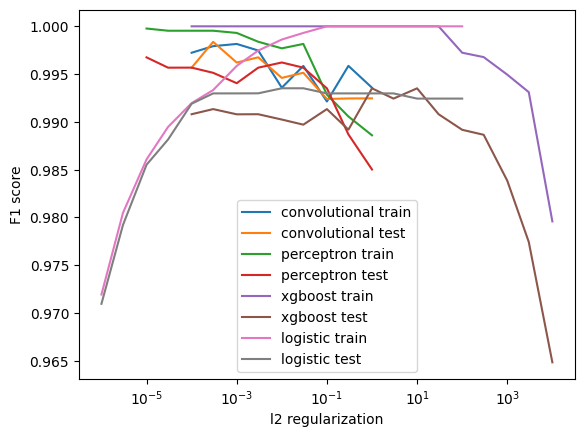

In [65]:
plt.plot(conv2d_stats[0],conv2d_stats[1],label='convolutional train')
plt.plot(conv2d_stats[0],conv2d_stats[2],label='convolutional test')
plt.plot(per_stats[0],per_stats[1],label='perceptron train')
plt.plot(per_stats[0],per_stats[2],label='perceptron test')
plt.plot(stats_xgb[0],stats_xgb[1],label='xgboost train')
plt.plot(stats_xgb[0],stats_xgb[2],label='xgboost test')
plt.plot(stats_log[0],stats_log[1],label='logistic train')
plt.plot(stats_log[0],stats_log[2],label='logistic test')
plt.legend(loc="best")
#plt.title('Loss vs Epochs')
plt.xlabel('l2 regularization')
plt.ylabel('F1 score')
#plt.ylim(0,0.7)
plt.xscale("log")
print("not regularized")
print(f"Logistic train {np.round(f1_score(target_train,l_train_pred),5)}")
print(f"Logistic test {np.round(f1_score(target_test,l_test_pred),5)}")
print(f"xgboost train {np.round(f1_score(target_train,x_pred_train),5)}")
print(f"xgboost test {np.round(f1_score(target_test,x_pred_test),5)}")
print(f"perceptron train {np.round(f1_score(target_train,np.round(p_pred_train)),5)}")
print(f"perceptron test {np.round(f1_score(target_test,np.round(p_pred_test)),5)}")
print(f"convolutional train {np.round(f1_score(target_train,np.round(c_pred_train)),5)}")
print(f"convolutional test {np.round(f1_score(target_test,np.round(c_pred_test)),5)}")
print("best regularized")
print(f"xgboost train {np.round(np.max(stats_xgb[1]),5)}")
print(f"xgboost test {np.round(np.max(stats_xgb[2]),5)}")
print(f"logistic train {np.round(np.max(stats_log[1]),5)}")
print(f"logistic test {np.round(np.max(stats_log[2]),5)}")
print(f"perceptron train {np.round(np.max(per_stats[1]),5)}")
print(f"perceptron test {np.round(np.max(per_stats[2]),5)}")
print(f"convolutional train {np.round(np.max(conv2d_stats[1]),5)}")
print(f"convolutional test {np.round(np.max(conv2d_stats[2]),5)}")

Is improved now in test for all besides xgboost for its stays constant. Best is convolutional network, then perceptron, then on the same level logistic and xgboost. There are so few wrong, that it can be partlz chnace. Log loss depends less on stat statistic, thus I also look on this measure now. 

not regularized
Logistic train 0.0
Logistic test 0.39888
xgboost train 0.00124
xgboost test 0.03244
perceptron train 0.02332
perceptron test 0.0355
convolutional train 0.00336
convolutional test 0.01615
best regularized
xgboost train 0.00099
xgboost test 0.02985
logistic train 1e-05
logistic test 0.0361
perceptron train 0.0009
perceptron test 0.04345
convolutional train 0.01014
convolutional test 0.00858


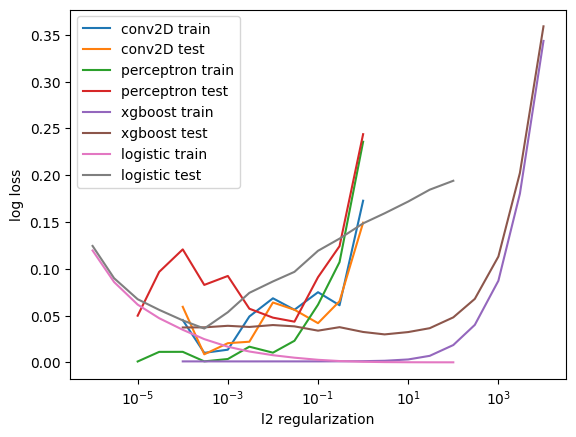

In [81]:
plt.plot(conv2d_stats[0],conv2d_stats[3],label='conv2D train')
plt.plot(conv2d_stats[0],conv2d_stats[4],label='conv2D test')
plt.plot(per_stats[0],per_stats[3],label='perceptron train')
plt.plot(per_stats[0],per_stats[4],label='perceptron test')
plt.plot(stats_xgb[0],stats_xgb[3],label='xgboost train')
plt.plot(stats_xgb[0],stats_xgb[4],label='xgboost test')
plt.plot(stats_log[0],stats_log[3],label='logistic train')
plt.plot(stats_log[0],stats_log[4],label='logistic test')
plt.legend(loc="best")
#plt.title('Loss vs Epochs')
plt.xlabel('l2 regularization')
plt.ylabel('log loss')
#plt.ylim(0,0.7)
plt.xscale("log")
print("not regularized")
print(f"Logistic train {np.round(log_loss(target_train,l_train_pred_prob),5)}")
print(f"Logistic test {np.round(log_loss(target_test,l_test_pred_prob),5)}")
print(f"xgboost train {np.round(log_loss(target_train,x_pred_prob_train),5)}")
print(f"xgboost test {np.round(log_loss(target_test,x_pred_prob_test),5)}")
print(f"perceptron train {np.round(log_loss(target_train,(p_pred_train)),5)}")
print(f"perceptron test {np.round(log_loss(target_test,(p_pred_test)),5)}")
print(f"convolutional train {np.round(log_loss(target_train,(c_pred_train)),5)}")
print(f"convolutional test {np.round(log_loss(target_test,(c_pred_test)),5)}")
print("best regularized")
print(f"xgboost train {np.round(np.min(stats_xgb[3]),5)}")
print(f"xgboost test {np.round(np.min(stats_xgb[4]),5)}")
print(f"logistic train {np.round(np.min(stats_log[3]),5)}")
print(f"logistic test {np.round(np.min(stats_log[4]),5)}")
print(f"perceptron train {np.round(np.min(per_stats[3]),5)}")
print(f"perceptron test {np.round(np.min(per_stats[4]),5)}")
print(f"convolutional train {np.round(np.min(conv2d_stats[3]),5)}")
print(f"convolutional test {np.round(np.min(conv2d_stats[4]),5)}")

Similar but not identical. Best is convoltional network, then xgboost, then logistic then perceptron, all achioeve rather values.

## Final fits

As the next step I run the best of all four algorithm. I decide to use log loss as to find the best one. 


First I print the values.

In [84]:
best_reg_conv=conv2d_stats[0,int(np.argmin(conv2d_stats[4,0:]))]
print(f"best regularization of convolutional is {best_reg_conv}")
best_reg_per=per_stats[0,(np.argmin(per_stats[4]))]
print(f"best regularization of perceptron is {best_reg_per}")
best_reg_xgb=stats_xgb[0,(np.argmin(stats_xgb[4]))]
print(f"best regularization of xgboost is {best_reg_xgb}")
best_reg_log=stats_log[0,(np.argmin(stats_log[4]))]
print(f"best regularization of logistic is {best_reg_log}")

best regularization of convolutional is 0.0003
best regularization of perceptron is 0.03
best regularization of xgboost is 3.0
best regularization of logistic is 0.0003


In [85]:
xc2=XGBClassifier(max_depth=6,reg_lambda=3.0).fit(feature_train,target_train)
x2_train_pred_prob=xc2.predict_proba(feature_train)
x2_test_pred_prob=xc2.predict_proba(feature_test)

In [86]:
lc2=LogisticRegression(penalty='l2',C=0.0003,max_iter=3000).fit(feature_train,target_train)
l2_train_pred_prob=lc2.predict_proba(feature_train)
l2_test_pred_prob=lc2.predict_proba(feature_test)

In [80]:
num_features=121
keep_prob=1
modelp =BinaryClassification3(num_features)            
modelp.to(device)
loss_stats_test3 = {
        'train': [], 'test': []
        }
torch_fit(modelp,train_loader,test_loader,200,64,0.001,loss_stats_test3,l2reg=0.03)
p2_test_pred=pred_torch(modelp,test_loader)
p2_train_pred=pred_torch(modelp,train_loader_pred)

Begin training.


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.38840 | Test Loss: 0.17213
Epoch 002: | Train Loss: 0.27422 | Test Loss: 0.27228
Epoch 003: | Train Loss: 0.29803 | Test Loss: 0.18071
Epoch 004: | Train Loss: 0.32367 | Test Loss: 0.25876
Epoch 005: | Train Loss: 0.29180 | Test Loss: 0.25983
Epoch 006: | Train Loss: 0.31184 | Test Loss: 0.25652
Epoch 007: | Train Loss: 0.28726 | Test Loss: 0.25025
Epoch 008: | Train Loss: 0.28421 | Test Loss: 0.26624
Epoch 009: | Train Loss: 0.32578 | Test Loss: 0.25650
Epoch 010: | Train Loss: 0.32512 | Test Loss: 0.25564
Epoch 011: | Train Loss: 0.31148 | Test Loss: 0.24919
Epoch 012: | Train Loss: 0.26411 | Test Loss: 0.19570
Epoch 013: | Train Loss: 0.30909 | Test Loss: 0.24582
Epoch 014: | Train Loss: 0.31838 | Test Loss: 0.25286
Epoch 015: | Train Loss: 0.30524 | Test Loss: 0.11984
Epoch 016: | Train Loss: 0.30872 | Test Loss: 0.12391
Epoch 017: | Train Loss: 0.28346 | Test Loss: 0.18588
Epoch 018: | Train Loss: 0.31051 | Test Loss: 0.12952
Epoch 019: | Train Loss: 0.3

Epoch 153: | Train Loss: 0.12220 | Test Loss: 0.16372
Epoch 154: | Train Loss: 0.04721 | Test Loss: 0.15947
Epoch 155: | Train Loss: 0.05000 | Test Loss: 0.16775
Epoch 156: | Train Loss: 0.06205 | Test Loss: 0.16350
Epoch 157: | Train Loss: 0.04415 | Test Loss: 0.23424
Epoch 158: | Train Loss: 0.05289 | Test Loss: 0.09459
Epoch 159: | Train Loss: 0.04726 | Test Loss: 0.09088
Epoch 160: | Train Loss: 0.04254 | Test Loss: 0.08995
Epoch 161: | Train Loss: 0.04203 | Test Loss: 0.09135
Epoch 162: | Train Loss: 0.05718 | Test Loss: 0.11296
Epoch 163: | Train Loss: 0.04577 | Test Loss: 0.09083
Epoch 164: | Train Loss: 0.04291 | Test Loss: 0.16418
Epoch 165: | Train Loss: 0.04238 | Test Loss: 0.10183
Epoch 166: | Train Loss: 0.04902 | Test Loss: 0.09528
Epoch 167: | Train Loss: 0.04306 | Test Loss: 0.10123
Epoch 168: | Train Loss: 0.04253 | Test Loss: 0.09400
Epoch 169: | Train Loss: 0.04407 | Test Loss: 0.06702
Epoch 170: | Train Loss: 0.04924 | Test Loss: 0.05472
Epoch 171: | Train Loss: 0.0

In [87]:
#slower than perceptron but not much 
keep_prob=1
modelc =CNNBinary3(keep_prob)            
modelc.to(device)
loss_stats_test_c = {
        'train': [], 'test': []
        }
torch_fit(modelc,train_im_loader,test_im_loader,200,64,0.001,loss_stats_test_c,l2reg=0.0003)
c2_test_pred=pred_torch(modelc,test_im_loader)
c2_train_pred=pred_torch(modelc,train_im_loader_pred)

Begin training.


/home/tobias/ml-testing/astr-images/functions_ml.py:133: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 1.32644 | Test Loss: 0.26636
Epoch 002: | Train Loss: 0.63149 | Test Loss: 0.32212
Epoch 003: | Train Loss: 0.32177 | Test Loss: 1.10056
Epoch 004: | Train Loss: 0.34294 | Test Loss: 0.17476
Epoch 005: | Train Loss: 0.85283 | Test Loss: 0.25036
Epoch 006: | Train Loss: 0.70979 | Test Loss: 0.77903
Epoch 007: | Train Loss: 0.17410 | Test Loss: 0.24201
Epoch 008: | Train Loss: 0.06484 | Test Loss: 0.16649
Epoch 009: | Train Loss: 0.04920 | Test Loss: 0.31028
Epoch 010: | Train Loss: 0.04605 | Test Loss: 0.17328
Epoch 011: | Train Loss: 0.01125 | Test Loss: 0.09842
Epoch 012: | Train Loss: 0.04254 | Test Loss: 0.04151
Epoch 013: | Train Loss: 0.06042 | Test Loss: 0.04394
Epoch 014: | Train Loss: 0.01305 | Test Loss: 0.03735
Epoch 015: | Train Loss: 0.01259 | Test Loss: 0.03499
Epoch 016: | Train Loss: 0.01215 | Test Loss: 0.03247
Epoch 017: | Train Loss: 0.01103 | Test Loss: 0.02796
Epoch 018: | Train Loss: 0.01949 | Test Loss: 0.02438
Epoch 019: | Train Loss: 0.0

Epoch 153: | Train Loss: 0.00101 | Test Loss: 0.08132
Epoch 154: | Train Loss: 0.00120 | Test Loss: 0.09073
Epoch 155: | Train Loss: 0.00146 | Test Loss: 0.08852
Epoch 156: | Train Loss: 0.00103 | Test Loss: 0.04362
Epoch 157: | Train Loss: 0.00228 | Test Loss: 0.04594
Epoch 158: | Train Loss: 0.00134 | Test Loss: 0.15533
Epoch 159: | Train Loss: 0.00098 | Test Loss: 0.09103
Epoch 160: | Train Loss: 0.00589 | Test Loss: 0.07045
Epoch 161: | Train Loss: 0.01041 | Test Loss: 0.07977
Epoch 162: | Train Loss: 0.00206 | Test Loss: 0.07914
Epoch 163: | Train Loss: 0.00191 | Test Loss: 0.08135
Epoch 164: | Train Loss: 0.00139 | Test Loss: 0.07910
Epoch 165: | Train Loss: 0.00103 | Test Loss: 0.09206
Epoch 166: | Train Loss: 0.00076 | Test Loss: 0.09286
Epoch 167: | Train Loss: 0.00077 | Test Loss: 0.09002
Epoch 168: | Train Loss: 0.00069 | Test Loss: 0.09583
Epoch 169: | Train Loss: 0.00088 | Test Loss: 0.08831
Epoch 170: | Train Loss: 0.00049 | Test Loss: 0.08450
Epoch 171: | Train Loss: 0.0

Now I am looking on wrong classifications concentrating on the ones which are clealy wrong. I print out the difference betwene model magnitude and star magnitude because that is around 0 for stars. 

In [89]:
c=0
for i in range(len(x2_test_pred_prob)):
    avg=(x2_test_pred_prob[i,1]+c2_test_pred[i]+p2_test_pred[i]+l2_test_pred_prob[i,1])/4
    p=np.array([l2_test_pred_prob[i,1],x2_test_pred_prob[i,1],p2_test_pred[i],c2_test_pred[i]])
    if abs(avg-target_test[i])>0.5:
        print(f"case {i} class is {df_test['class'].iat[i]} with p(galaxy) {np.round(p,3)}")
        print(f"Mag(model)-Mag(star)={np.round(df_test.modelMag_r.iat[i]-df_test.psfMag_r.iat[i],3)}")
        if df_test['class'].iat[i]=='GALAXY':
            print(f"redshift is {np.round(df_test.redshift.iat[i],4)}")
        else:
            print(f"velocity is {np.round(df_test.redshift.iat[i]*299792)}")
        c+=1
print(c)        
diff2=df2[df2['class']=='GALAXY'].modelMag_r-df2[df2['class']=='GALAXY'].psfMag_r
print(diff2.describe())

case 22 class is GALAXY with p(galaxy) [0.305 0.028 0.124 0.15 ]
Mag(model)-Mag(star)=-0.234
redshift is 0.4016
case 239 class is GALAXY with p(galaxy) [0.296 0.224 0.384 1.   ]
Mag(model)-Mag(star)=-0.312
redshift is 0.1316
case 915 class is STAR with p(galaxy) [0.553 0.087 0.828 0.819]
Mag(model)-Mag(star)=-0.023
velocity is 117.0
case 1092 class is GALAXY with p(galaxy) [0.006 0.277 0.762 0.   ]
Mag(model)-Mag(star)=-0.294
redshift is 0.1381
case 1131 class is STAR with p(galaxy) [1.    0.624 0.553 1.   ]
Mag(model)-Mag(star)=-0.001
velocity is -26.0
case 1289 class is GALAXY with p(galaxy) [0.044 0.052 0.058 0.   ]
Mag(model)-Mag(star)=-0.21
redshift is 0.5941
6
count    3092.000000
mean       -1.374348
std         0.633466
min        -6.088180
25%        -1.676228
50%        -1.268105
75%        -0.932505
max        -0.176110
dtype: float64


Looking on the properties of table, I have not yet found something obvious which hints that input classifications are faulty. The galaxies included here are more compact than most, that is expected that the galaxies with the problems are the compact ones, but that is true for both wrong classifications in the labels and by the algorithms. They are not obvious outliers, see plot below. Likely the sample is too small to be able to distinguish the options. 

(0.1, -1.0)

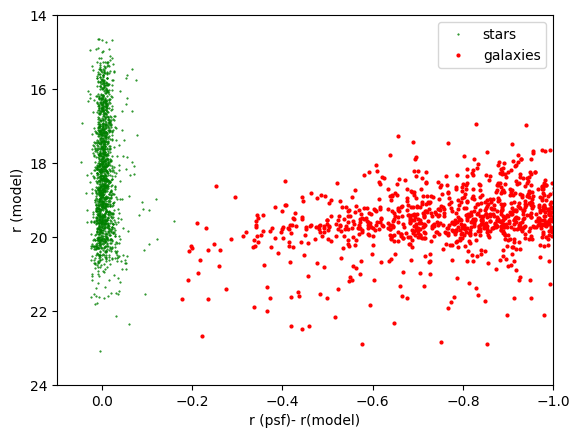

In [136]:
plt.plot(df2['modelMag_r'][df2['class']=='STAR']-df2['psfMag_r'][df2['class']=='STAR'],df2['modelMag_r'][df2['class']=='STAR'],'o',ms=0.5,color='green',label='stars')
plt.plot(df2['modelMag_r'][df2['class']=='GALAXY']-df2['psfMag_r'][df2['class']=='GALAXY'],df2['modelMag_r'][df2['class']=='GALAXY'],'o',ms=2,color='red',label='galaxies') 
plt.legend(loc="best")
plt.xlabel("r (psf)- r(model)")
plt.ylabel("r (model)")
plt.ylim(24,14)
plt.xlim(0.1,-1)
#plt.yscale("log")

Below I plot the images of the objects with classfications problems. 

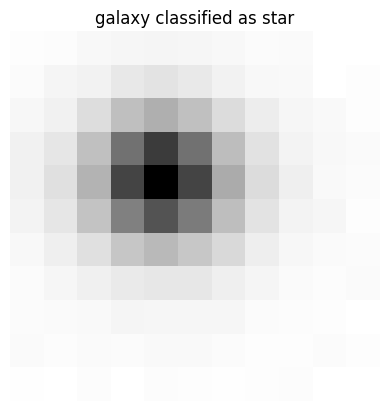

In [90]:
#all methods agree 
plt.axis('off')
plt.title("galaxy classified as star")
plt.imshow(-image_test[22,0,:,:].T,cmap=cm.gray, interpolation='nearest')

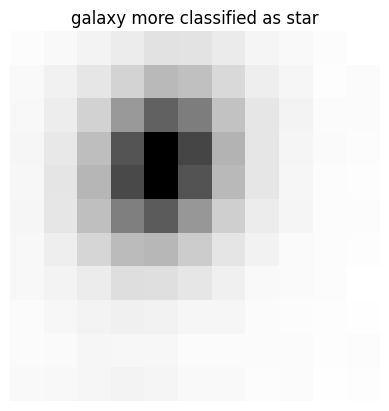

In [91]:
#convolutional different
plt.axis('off')
plt.title("galaxy more classified as star")
plt.imshow(-image_test[239,0,:,:].T,cmap=cm.gray, interpolation='nearest')

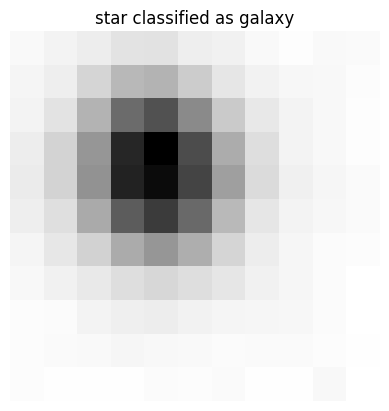

In [92]:
#xgboost disgarees 
plt.axis('off')
plt.title("star classified as galaxy")
plt.imshow(-image_test[915,0,:,:].T,cmap=cm.gray, interpolation='nearest')

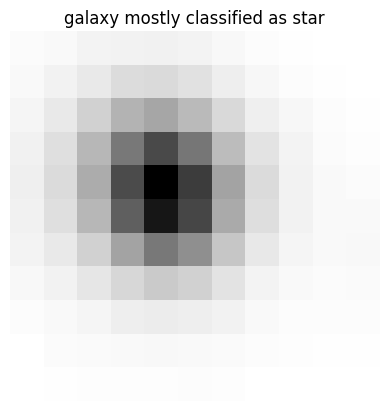

In [93]:
#perceptron is different from other methods
plt.axis('off')
plt.title("galaxy mostly classified as star")
plt.imshow(-image_test[1092,0,:,:].T,cmap=cm.gray, interpolation='nearest')

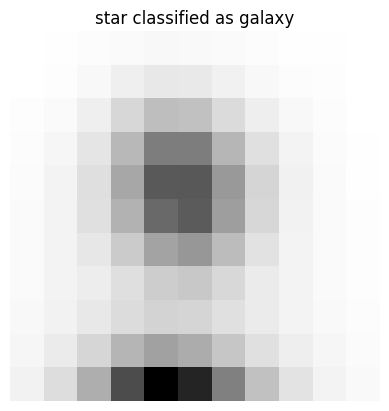

In [94]:
#all agree
plt.axis('off')
plt.title("star classified as galaxy")
plt.imshow(-image_test[1131,0,:,:].T,cmap=cm.gray, interpolation='nearest')

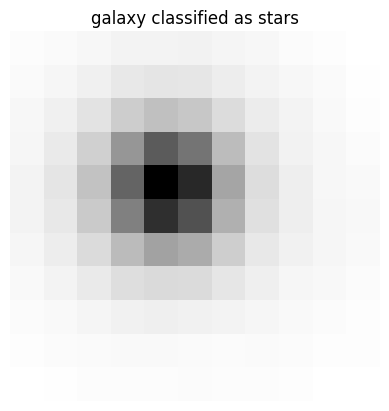

In [96]:
#all agree
plt.axis('off')
plt.title("galaxy classified as stars")
plt.imshow(-image_test[1289,0,:,:].T,cmap=cm.gray, interpolation='nearest')

The one above all look rather normal compact, there few if at all obvious galaxies to the eye.
All of those look rather round per eye and when there are differences it is in the level of concentration. The human eye is not particularly good in finding that. Thus looking on the images does not help. Algorithm are better. 

## Conclusions

It is rather to get a good classfication into star and galaxies, even simple methods like logistic achive very good results. None it is perfect, the reason for that is not clear, there are no clear problems with input classifications. Using more data likely helps to solve this problem.
For this prob;em it also would makes to look on others methods because the star class is very homogenous outlier detection methods are possible better. Also looking on shape based parameters like moments could be useful. 
That also simpler algorithms work well shows not unexpected that is not the best use case for neural networks. Still, they are also work. 